# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import xgboost as xgb

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

def regression_metrics(y_test, y_pred):
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))

def binary_classifier_metrics(y_test, y_pred):
    '''
    Quick function to return metrics for binary classification models.
    Requires the imports of the functions below.
    '''
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('Precision score: ', precision_score(y_test, y_pred))
    print('Recall score: ', recall_score(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [3]:
#df_flights = pd.read_csv('data/features_after_EDA.csv')
clean_df = pd.read_csv('data/clean_df.csv')

In [4]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314184 entries, 0 to 1314183
Data columns (total 36 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Unnamed: 0                1314184 non-null  int64  
 1   mkt_unique_carrier        1314184 non-null  object 
 2   mkt_carrier_fl_num        1314184 non-null  int64  
 3   tail_num                  1314184 non-null  object 
 4   origin                    1314184 non-null  object 
 5   dest                      1314184 non-null  object 
 6   crs_dep_time              1314184 non-null  int64  
 7   crs_arr_time              1314184 non-null  int64  
 8   arr_delay                 1314184 non-null  float64
 9   distance                  1314184 non-null  float64
 10  dep_period                1314184 non-null  object 
 11  arr_period                1314184 non-null  object 
 12  origin_match_code         1314184 non-null  object 
 13  dest_match_code           1

In [5]:
features = ['distance',                    
'dep_period',                   
'arr_period',                   
'origin_weather_condition',     
'origin_weather_severity',      
'dest_weather_condition',       
'dest_weather_severity',        
'week_day',                     
'crs_dep_hour',                  
'crs_arr_hour',                  
'carrier_on_time_pct',         
'plane_on_time_pct',           
'origin_on_time_pct',          
'fl_num_on_time_pct',          
'route_on_time_pct',
'haul_type',
'arr_delay']          

In [6]:
df_flights = clean_df[features]

In [7]:
df_flights.head()

,distance,dep_period,arr_period,origin_weather_condition,origin_weather_severity,dest_weather_condition,dest_weather_severity,week_day,crs_dep_hour,crs_arr_hour,carrier_on_time_pct,plane_on_time_pct,origin_on_time_pct,fl_num_on_time_pct,route_on_time_pct,haul_type,arr_delay
0,157.0,Evening,Evening,Clear,Light,Clear,Light,Tuesday,21,23,0.630446,0.624309,0.700976,0.511811,0.704348,Short,-3.0
1,313.0,Morning,Afternoon,Adverse,Moderate,Clear,Light,Tuesday,11,13,0.630446,0.560345,0.696741,0.538889,0.678571,Short,6.0
2,313.0,Morning,Morning,Adverse,Light,Adverse,Moderate,Tuesday,10,11,0.630446,0.560345,0.672548,0.538889,0.594458,Short,14.0
3,396.0,Evening,Evening,Clear,Light,Clear,Light,Tuesday,20,21,0.630446,0.569061,0.672548,0.577640,0.512821,Short,-12.0
4,290.0,Afternoon,Afternoon,Clear,Light,Clear,Light,Tuesday,12,13,0.630446,0.663158,0.656380,0.553459,0.710579,Short,-14.0


In [8]:
# Remove Outliners

In [9]:
# arr_delay outliners
Q1_arrival = df_flights.arr_delay.quantile(0.25)
Q3_arrival = df_flights.arr_delay.quantile(0.75)
IQR = Q3_arrival - Q1_arrival
df_flights = df_flights.loc[(df_flights['arr_delay'] >= (Q1_arrival - 1.5*IQR))\
                                     & (df_flights['arr_delay'] <= Q3_arrival + 1.5*IQR)]

In [10]:
df_flights.shape

(1200213, 17)

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [11]:
# Check missing data on flights
flights_missing = check_missing_data(df_flights)
flights_missing

,Total,Percent
distance,0,0.0
crs_arr_hour,0,0.0
haul_type,0,0.0
route_on_time_pct,0,0.0
fl_num_on_time_pct,0,0.0
origin_on_time_pct,0,0.0
plane_on_time_pct,0,0.0
carrier_on_time_pct,0,0.0
crs_dep_hour,0,0.0
dep_period,0,0.0


In [12]:
print(df_flights.shape)
df_flights = df_flights.dropna(how='any',axis=0) 
print(df_flights.shape)

(1200213, 17)
(1200213, 17)


In [13]:
numeric_cols = df_flights.dtypes[(df_flights.dtypes =='int64')|(df_flights.dtypes =='float64')].index.to_list()
categorical_cols = df_flights.dtypes[df_flights.dtypes == 'object'].index.to_list()

In [14]:
numeric_cols_exclude_target = list(set(numeric_cols) - {'arr_delay'} )

In [15]:
categorical_cols

['dep_period',
 'arr_period',
 'origin_weather_condition',
 'origin_weather_severity',
 'dest_weather_condition',
 'dest_weather_severity',
 'week_day',
 'haul_type']

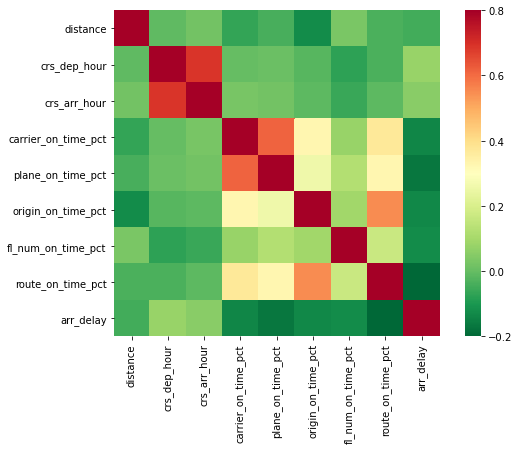

In [16]:
# correlation matrix
corrmat = df_flights[numeric_cols].corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn_r");

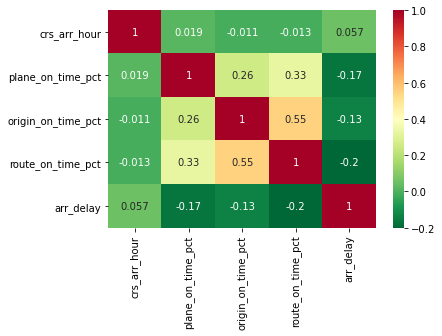

In [17]:
corr_matrix = corrmat.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.2
top_corr_features = [column for column in upper.columns if any(upper[column] > 0.2)]

# most correlated features with arr_delay
sns.heatmap(df_flights[top_corr_features].corr(),annot=True,cmap="RdYlGn_r");

In [18]:
df_dummy = pd.get_dummies(df_flights[categorical_cols], drop_first=True)

In [19]:
df_dummy.head()

,dep_period_Evening,dep_period_Morning,dep_period_Night,arr_period_Evening,arr_period_Morning,arr_period_Night,origin_weather_condition_Clear,origin_weather_severity_Moderate,origin_weather_severity_Severe,dest_weather_condition_Clear,dest_weather_severity_Moderate,dest_weather_severity_Severe,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,haul_type_Medium,haul_type_Short
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [20]:
df_num_scaled = StandardScaler().fit_transform(df_flights[numeric_cols_exclude_target])

In [21]:
X_encoded = pd.concat([df_flights[numeric_cols_exclude_target], df_dummy], axis=1)
X_encoded_scaled = np.hstack((df_num_scaled,df_dummy.to_numpy()))
y = df_flights['arr_delay']

In [22]:
X_encoded.head()

,distance,plane_on_time_pct,origin_on_time_pct,crs_dep_hour,carrier_on_time_pct,fl_num_on_time_pct,route_on_time_pct,crs_arr_hour,dep_period_Evening,dep_period_Morning,...,dest_weather_severity_Moderate,dest_weather_severity_Severe,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,haul_type_Medium,haul_type_Short
0,157.0,0.624309,0.700976,21,0.630446,0.511811,0.704348,23,1,0,...,0,0,0,0,0,0,1,0,0,1
1,313.0,0.560345,0.696741,11,0.630446,0.538889,0.678571,13,0,1,...,0,0,0,0,0,0,1,0,0,1
2,313.0,0.560345,0.672548,10,0.630446,0.538889,0.594458,11,0,1,...,1,0,0,0,0,0,1,0,0,1
3,396.0,0.569061,0.672548,20,0.630446,0.577640,0.512821,21,1,0,...,0,0,0,0,0,0,1,0,0,1
4,290.0,0.663158,0.656380,12,0.630446,0.553459,0.710579,13,0,0,...,0,0,0,0,0,0,1,0,0,1


In [32]:
# Train Test Split
#X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size = 0.25)
X_train, X_val, y_train, y_val = train_test_split(X_encoded_scaled, y, test_size = 0.25)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [31]:
#1. Linear regression on scaled data
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
y_pred_l_reg = l_reg.predict(X_val)
regression_metrics(y_val, y_pred_l_reg)

R2 Score:  0.08386126961536666
Mean Absolute Error:  12.560441218909757
Mean Squared Error:  263.1093365525846


In [25]:
#2. Ridge Regression with GridSearchCV
rr = Ridge()
parameters = {'alpha':[0.01,0.1,0.5,1,5]}
ridge_tuned = GridSearchCV(rr,param_grid=parameters, scoring='r2', cv=10)

In [26]:
ridge_tuned.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 5]}, scoring='r2')

In [28]:
y_pred_Ridge_tuned = ridge_tuned.predict(X_val)

In [29]:
regression_metrics(y_val, y_pred_Ridge_tuned)

R2 Score:  0.08362194210025864
Mean Absolute Error:  12.578614245846246
Mean Squared Error:  264.0396482065248


In [33]:
#3. XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 50)

xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
y_pred_xgb_reg = xg_reg.predict(X_val)

In [36]:
regression_metrics(y_val, y_pred_xgb_reg)

R2 Score:  0.10668329555240375
Mean Absolute Error:  12.421430097310092
Mean Squared Error:  258.1148778580537


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.